In [1]:
# work in progress

In [2]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd()
if PROJECT_DIR.stem == 'notebooks':
    PROJECT_DIR = PROJECT_DIR.parent
    sys.path.insert(0, '..')

INTERACTIVE_PLOTTING = True

In [3]:
import logging
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from src.psychopy.calibration import BayesianEstimatorVAS
from src.log_config import configure_logging
configure_logging()

In [4]:
def plot_trials(estimator, interactive=True):
    
    priors = estimator.priors
    likelihoods = estimator.likelihoods
    posteriors = estimator.posteriors
    range_temperature = estimator.range_temp
    min_temperature = estimator.min_temp
    max_temperature = estimator.max_temp
    trials = estimator.trials
    
    if interactive:
    # reload vs window if plot appears twice
        import ipywidgets as widgets 
        from IPython.display import display

        def plot_trial(trial):
            plt.clf()
            plt.plot(range_temperature, priors[trial], label='Prior')
            plt.plot(range_temperature, likelihoods[trial], label='Likelihood')
            plt.plot(range_temperature, posteriors[trial], label='Posterior')
            plt.title(f'Trial {trial+1} of {trials}')
            plt.xlim([min_temperature, max_temperature])
            plt.ylim([0, 1])
            plt.xlabel('Temperature (°C)')
            plt.ylabel('Probability')
            plt.xticks(np.arange(min_temperature, max_temperature+1, 1))
            plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

        # Create a slider for the trial number
        trial_slider = widgets.IntSlider(min=0, max=trials-1, step=1, value=0);

        # Create Next and Previous buttons, define click events and link them to the buttons
        next_button = widgets.Button(description="Next")
        prev_button = widgets.Button(description="Previous")
        def next_button_clicked(b): # b is the button instance
            if trial_slider.value < trial_slider.max:
                trial_slider.value += 1
        def prev_button_clicked(b):
            if trial_slider.value > trial_slider.min:
                trial_slider.value -= 1
        next_button.on_click(next_button_clicked)
        prev_button.on_click(prev_button_clicked)

        # Use the interact function to automatically update the plot when the slider is moved
        out = widgets.interactive_output(plot_trial, {'trial': trial_slider});

        # Display the slider and the buttons on top of the figure (box on box)
        display(widgets.VBox([widgets.HBox([trial_slider, prev_button, next_button]), out]))
        
    else:
        # One figure with all trials
        fig, ax = plt.subplots(trials, 1, figsize=(5, 10))
        for trial in range(trials):
            ax[trial].plot(range_temperature, priors[trial], label='Prior')
            ax[trial].plot(range_temperature, likelihoods[trial], label='Likelihood')
            ax[trial].plot(range_temperature, posteriors[trial], label='Posterior')
            ax[trial].set_title(f'Trial {trial+1}')

            # Add x-axis label to the last diagram only
            if trial == trials - 1:
                ax[trial].set_xlabel('Temperature (°C)')
        plt.tight_layout()
        plt.show()


# Visualization of Calibration

In [5]:
# Preexposure
preexposure_temperatures = [35, 36, 37]
correction_after_preexposure = 2

# VAS 70 estimation
trials_vas70 = 7
temp_start_vas70 = 42.
temp_std_vas70 = 3.5

# VAS 0 estimation
trials_vas0 = 5
temp_start_vas0 = None # based on VAS 70 estimation
temp_start_vas0_minus = 3
temp_start_vas0_std = 1.5


In [6]:

response = input(f'Were any of the preexposure stimuli ({str(preexposure_temperatures)} °C) painful? (y/n) ')
if response == "y":
    temp_start_vas70 = 40.
    logging.info(f"Calibration preexposure was painful. Starting temperature for VAS 70 estimation: {temp_start_vas70} °C.")
else:
    temp_start_vas70 = 42. - correction_after_preexposure
    logging.info(f"Calibration preexposure was not painful. Starting temperature for VAS 70 estimation: {temp_start_vas70} °C.")

[10:43:52] [INFO] [root] - Calibration preexposure was not painful. Starting temperature for VAS 70 estimation: 40.0 °C.


In [7]:
# Get estimate for VAS 70
trials = 7
estimator_vas70 = BayesianEstimatorVAS(
    vas_value= 70, 
    temp_start=temp_start_vas70, 
    temp_std=temp_std_vas70,
    trials=trials)

for trial in range(estimator_vas70.trials):
    response = input('Is this stimulus painful? (y/n) ') 
    estimator_vas70.conduct_trial(response,trial=trial)

logging.info(f"Estimated temperature for VAS 50: {estimator_vas70.get_estimate()} °C")

[10:43:52] [INFO] [calibration] - Calibration trial (1/7): 40.0 °C was under VAS 70.
[10:43:52] [INFO] [calibration] - Calibration trial (2/7): 41.6 °C was under VAS 70.
[10:43:52] [INFO] [calibration] - Calibration trial (3/7): 42.8 °C was under VAS 70.
[10:43:52] [INFO] [calibration] - Calibration trial (4/7): 43.8 °C was under VAS 70.
[10:43:52] [INFO] [calibration] - Calibration trial (5/7): 44.7 °C was under VAS 70.
[10:43:52] [INFO] [calibration] - Calibration trial (6/7): 45.5 °C was under VAS 70.
[10:43:52] [INFO] [calibration] - Calibration trial (7/7): 46.0 °C was under VAS 70.
[10:43:52] [INFO] [calibration] - Calibration estimate for VAS 70: 46.0 °C.
[10:43:52] [INFO] [calibration] - Calibration steps were (°C): [1.6 1.2 1.  0.9 0.8 0.5 0. ].
[10:43:52] [WARNING] [calibration] - Calibration steps were all in the same direction.
[10:43:52] [INFO] [root] - Estimated temperature for VAS 50: 46.0 °C


In [8]:
plot_trials(estimator_vas70, interactive=True)

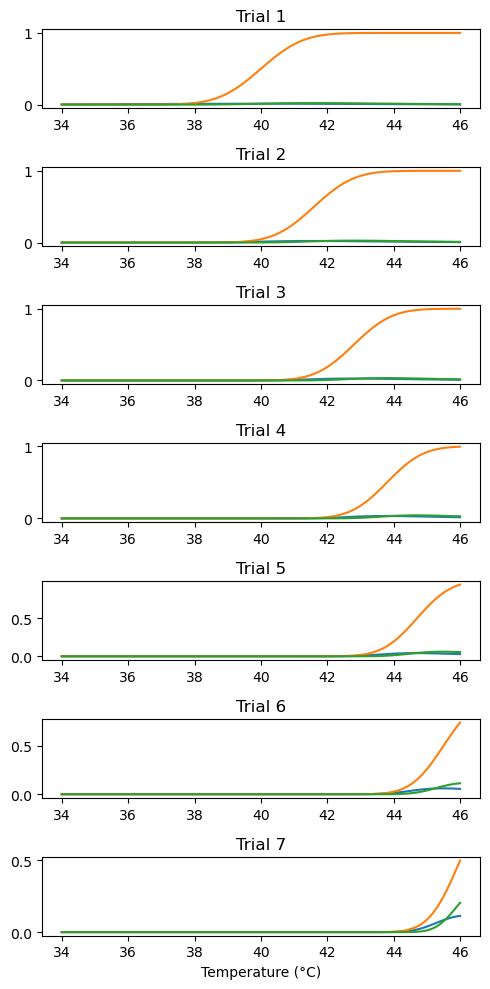

In [9]:
plot_trials(estimator_vas70, interactive=False)